In [32]:
import torch
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import save_image
# Import Numpy
import numpy as np
# Plot Import
import matplotlib.pyplot as plt
# For timer
import time
# Import OS
import os
# import local libs
import ecg_tools_lite as et

from statistics import mean

if not os.path.exists('./mlp_img'):
    os.mkdir('./mlp_img')

In [33]:
device = torch.device( 'cuda' if torch.cuda.is_available() else 'cpu')
print("Device:", device, time.localtime().tm_mon, "/", time.localtime().tm_mday, "/", time.localtime().tm_year)

Device: cuda 11 / 18 / 2020


In [34]:
ecg_clean = et.load_ecg_file('all_chunks_fs1024_e24.npy')
ecg_noisy = et.load_ecg_file('all_chunks_fs1024_e06.npy')

trainloader = DataLoader( ecg_noisy, shuffle=True, num_workers=2 )
# testloader = DataLoader()

# Testing Autoencoder

In [35]:
# # Example
# m = nn.Conv1d(16, 33, 3, stride=2)
# n = nn.ConvTranspose1d(33, 16, 3, stride=1)
# input_test = torch.randn(20, 16, 50)
# ym = m(input_test)
# yn = n(ym)
# output = m(input_test)

In [36]:
# Smaller version of the chiang ae

# x1 = nn.Conv1d(1024, )

In [37]:
class ae_tester(nn.Module):
    def __init__(self, input_dim):
        super(ae_tester, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv1d(
                in_channels=input_dim,
                out_channels=40, #filters
                kernel_size=16, #16
                stride=2,
                padding=int((16)/2)
            ),
            nn.Conv1d(40, 20, 16, stride=2, padding=int((16)/2)),
            nn.Conv1d(20, 20, 16, stride=2, padding=int((16)/2)),
            nn.Conv1d(20, 40, 16, stride=2, padding=int((16)/2)),
            nn.Conv1d(40, 1, 16, stride=1, padding=int((16)/2)),
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose1d(
                in_channels=1,
                out_channels=40,
                kernel_size=16,
                stride=1,
                # padding=int((16)/2)
            ),
            nn.ConvTranspose1d(40, 20, 16, stride=2),
            nn.ConvTranspose1d(20, 20, 16, stride=2),
            nn.ConvTranspose1d(20, 20, 16, stride=2),
            nn.ConvTranspose1d(20, 40, 16, stride=2),
            nn.ConvTranspose1d(40, input_dim, 16, stride=1),
        )

    def forward(self, x):
        x1 = self.encoder(x)
        x2 = self.decoder(x1)

        return x2

In [38]:
def train_model(model, train_set, lr, epochs):
    
    lr = 1e-3 if None else lr
    criterion = nn.MSELoss(size_average=False)
    optimizer = torch.optim.Adam(model.parameters())
    
    print( train_set.shape[0], train_set.shape[1])
    
    mean_losses = []

    for epoch in range(epochs):
        model.train()
        losses = []
        print(epoch)
        for x in train_set:
            # Added below to make it compatible with a 3 dimensional weight of the model
            # x = x.view(1, x.shape[0], x.shape[1])
            optimizer.zero_grad()
            x_prime = model(x)
            loss = criterion(x_prime, x)
            loss.backward()
            optimizer.step()
            losses.append(loss.item())
        
        mean_loss = mean(losses)
        mean_losses.append(mean_loss)
        print(f"Epoch: {epoch}, Loss: {mean_loss}")
    return mean_losses


In [39]:
train_set = torch.from_numpy(ecg_clean)
train_set = train_set[0:4]

In [40]:
# train_set = train_set.view(train_set.shape[0], train_set.shape[1], 1)

In [41]:
model = ae_tester(train_set.shape[2])
model.double()
train_model( model, train_set, None, epochs=1)

4 1024
0


RuntimeError: Expected 3-dimensional input for 3-dimensional weight [40, 1, 16], but got 2-dimensional input of size [1024, 1] instead

In [26]:
# mp = model.parameters()
# for i in mp:
#     print(i)

In [27]:
result_test = model.encoder(train_set)
result_final = model.decoder(result_test)

In [28]:
result_test.shape

torch.Size([4, 1, 2])

(4, 1, 2)

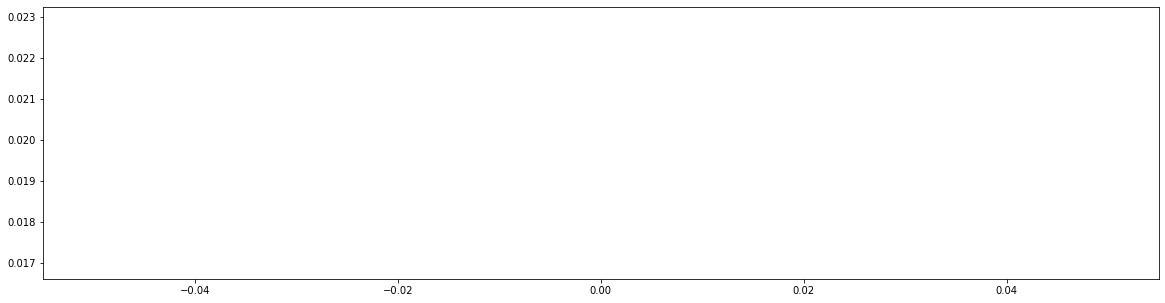

In [29]:
plot_res_final = result_test.detach().numpy()
plt.figure(figsize=(20,5))
plt.plot(plot_res_final[0][0:], c="red")
# plt.plot(train_set[0])
plot_res_final.shape

## Below sample

https://stackoverflow.com/questions/60591140/i-dont-understand-pytorch-input-sizes-of-conv1d-conv2d

Has an explanation, read again

In [30]:
# class ConvModel(nn.Module):
#     def __init__(self):
#         # input [B, 2, 18]
#         self.conv1 = nn.Conv1d(in_channels=2, out_channels=C1, kernel_size=3, padding=1)
#         # [B, C1, 18]
#         self.maxpool = nn.MaxPool1d(kernel_size=3, stride=3)
#         # [B, C1, 6]    (no alignment issue b/c 18 is a multiple of 3)
#         self.conv2 = nn.Conv1d(C1, C2, kernel_size=3, padding=1)
#         # [B, C2, 6]
#         self.fc1 = nn.Linear(C2*6, F1)
#         # [B, F1]
#         self.fc2 = nn.Linear(F1, F2)
#         # [B, F2]
#         self.fc2 = nn.Linear(F2, 2)
#         # [B, 2]

#     def forward(x):
#         x = F.relu(self.mp(self.conv1(x)))
#         x = self.maxpool(x)

#         x = F.relu(self.mp(self.conv2(x)))
#         x = self.maxpool(x)

#         x = x.flatten(1) # flatten the tensor starting at dimension 1

#         x = F.relu(self.fc1(x))
#         x = F.relu(self.fc2(x))
#         x = self.fc3(x)

#         return x

In [31]:
# conv1 = nn.Conv2d(3, 1, 3)
# weight = conv1.weight.data.numpy()
# plt.imshow(weight[0, ...])

In [58]:
train_set.shape

torch.Size([4, 1024, 1])

In [59]:
basic_data = train_set

In [66]:
d = 4
class Autoencoder_Basic(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(1024, d),
            nn.Tanh(),
        )
        # self.decoder = nn.Sequential(
        #     nn.Linear(d, 1024),
        #     nn.Tanh(),
        # )

    def forward(self, x):
        x = self.encoder(x)
        # x = self.decoder(x)
        return x
    
model_basic = Autoencoder_Basic().to(device)
criterion = nn.MSELoss()


# Configure the optimiser

learning_rate = 1e-3

optimizer = torch.optim.Adam(
    model.parameters(),
    lr=learning_rate,
)




# Train standard or denoising autoencoder (AE)

num_epochs = 20
# do = nn.Dropout()  # comment out for standard AE
for epoch in range(num_epochs):
    for data in basic_data:
        single_ecg = data
        single_ecg = single_ecg.to(device)
        # noise = do(torch.ones(img.shape)).to(device)
        # img_bad = (img * noise).to(device)  # comment out for standard AE
        # ===================forward=====================
        output = model_basic(single_ecg)  # feed <img> (for std AE) or <img_bad> (for denoising AE)
        loss = criterion(output, single_ecg)
        # ===================backward====================
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # ===================log========================
    print(f'epoch [{epoch + 1}/{num_epochs}], loss:{loss.item():.4f}')
    display_images(None, output)  # pass (None, output) for std AE, (img_bad, output) for denoising AE



RuntimeError: mat1 dim 1 must match mat2 dim 0